<a href="https://colab.research.google.com/github/MehrdadJalali-AI/MOF_LENS/blob/main/MOF_LENS_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/GAN-NodeGeneration/')
!pip install rdkit
!pip install deap

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00


LEA Best Fitness: 11.5328, Time: 27.58s
LEA Top 5 MOFs: ['AHARUY', 'PAXPIQ', 'PAXPIQ', 'KUNCUT', 'GALHUY']
Unique MOFs in Top 5: 4
Average Distance Between Top Solutions: 0.8659
Range Compliance: 0.00%
LEA Porosity Score: 1.0816, Stability Score: 0.5131
DE Best Fitness: -0.7252, Time: 12.53s
DE Porosity Score: 0.9128, Stability Score: 0.4439
GA Best Fitness: -19.9490, Time: 28.80s
GA Porosity Score: 1.8411, Stability Score: 1.7666
Number of Clusters in LEA Top Solutions: 3


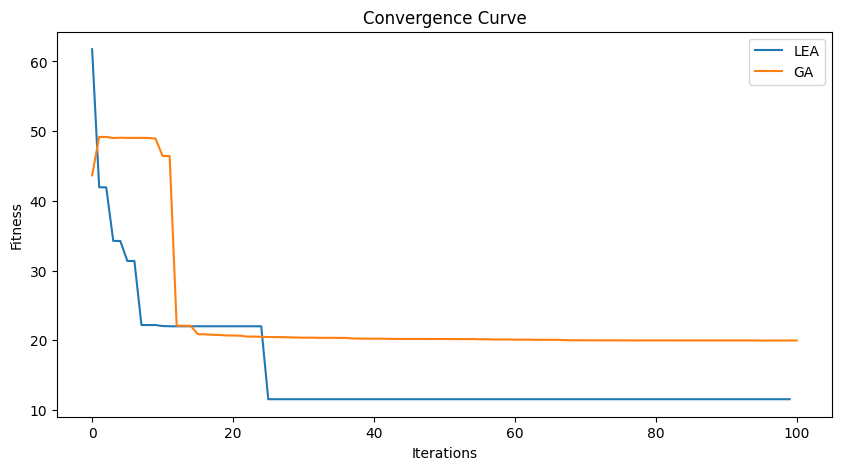

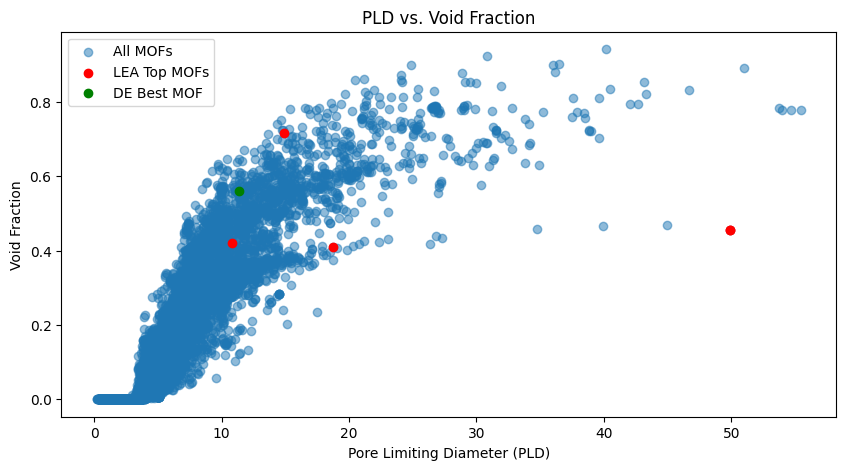

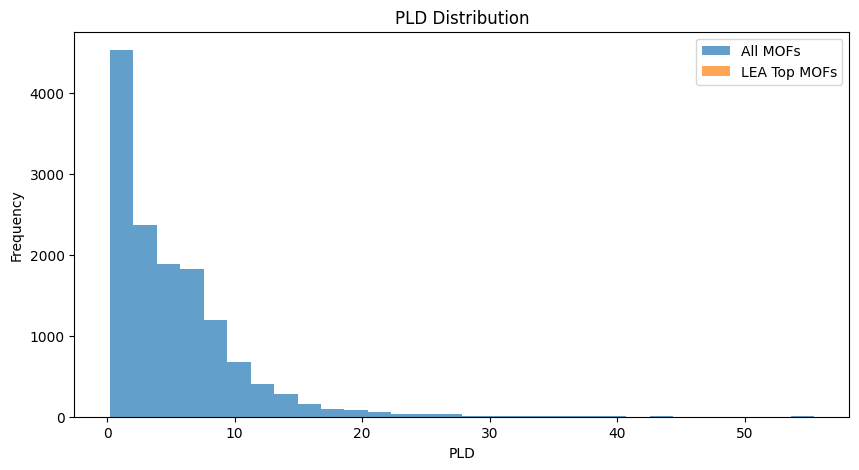

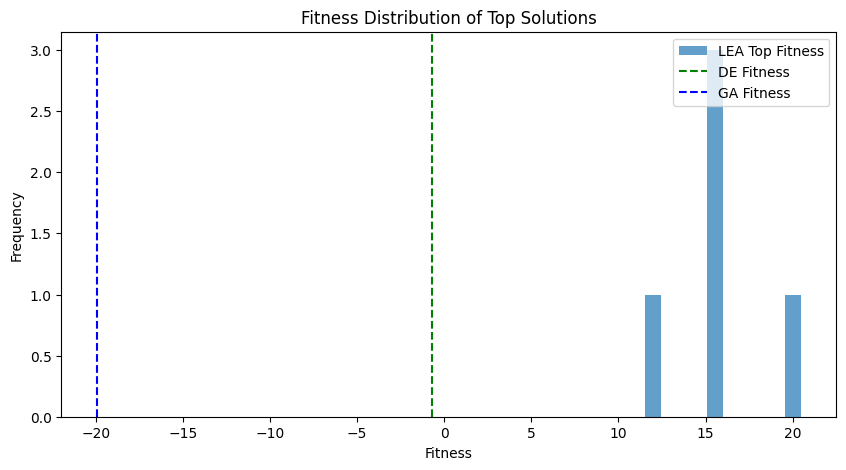

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import differential_evolution
from deap import base, creator, tools, algorithms
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
import warnings
# Suppress RDKit warnings (for potential future use with SMILES)
from rdkit import rdBase
rdBase.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")

# Load MOF dataset
file_path = "MOF.csv"  # Adjust path as needed
df = pd.read_csv(file_path)

# Extract relevant columns
features = ['Refcode', 'void_fraction', 'asa (A^2)', 'pld (A)', 'max_metal_coordination_n', 'n_sbu_point_of_extension']
df = df[features]

# Normalize data (0 to 1) except Refcode
df_norm = df.copy()
min_vals = df[features[1:]].min()
max_vals = df[features[1:]].max()
df_norm[features[1:]] = (df[features[1:]] - min_vals) / (max_vals - min_vals)

# User-defined ranges (in raw scale, will be normalized)
raw_ranges = {
    'void_fraction': (0.5, 0.8),
    'asa (A^2)': (800, 1000),
    'pld (A)': (10, 15),
    'max_metal_coordination_n': (6, 8),
    'n_sbu_point_of_extension': (4, 6)
}

# Normalize ranges to match df_norm
ranges = {feat: ((raw_ranges[feat][0] - min_vals[feat]) / (max_vals[feat] - min_vals[feat]),
                 (raw_ranges[feat][1] - min_vals[feat]) / (max_vals[feat] - min_vals[feat]))
          for feat in raw_ranges}

# Define fitness function with normalized values and dynamic penalties
def fitness_function(solution, df_norm, ranges, nbrs):
    porosity_score = solution[0] + solution[1] + solution[2]  # Void Fraction + ASA + PLD
    stability_score = solution[3] + solution[4]  # Metal Coordination + SBU Points
    total_score = -(porosity_score * 0.6 + stability_score * 0.4)  # Negative for minimization

    # Penalty for out-of-range values using normalized data
    penalty = 0
    mof_idx = nbrs.kneighbors([solution], n_neighbors=1, return_distance=False)[0][0]
    for i, feat in enumerate(features[1:]):
        actual_value = df_norm[feat].iloc[mof_idx]
        min_val, max_val = ranges[feat]
        if actual_value < min_val:
            penalty += abs(actual_value - min_val) / (max_val - min_val) * 10
        elif actual_value > max_val:
            penalty += abs(actual_value - max_val) / (max_val - min_val) * 10
    return total_score + penalty

# Lotus Effect Algorithm (LEA) Class
class LotusEffectAlgorithm:
    def __init__(self, population_size, dimensions, max_iterations, fitness_function, df_norm, ranges, k=5):
        self.population_size = population_size
        self.dimensions = dimensions
        self.max_iterations = max_iterations
        self.fitness_function = fitness_function
        self.df_norm = df_norm
        self.ranges = ranges
        self.population = np.random.rand(population_size, dimensions)
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.best_mof_name = None
        self.top_k_solutions = []  # Store top-k solutions
        self.k = k
        # Precompute kNN index
        self.nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(df_norm[features[1:]])
        # Dynamic step size based on feature range
        self.step_size = 0.05 * (df_norm[features[1:]].max() - df_norm[features[1:]].min()).values

    def levy_flight(self):
        beta = 1.5
        sigma = (gamma(1 + beta) * np.sin(np.pi * beta / 2) /
                 (gamma((1 + beta) / 2) * beta * 2**((beta - 1) / 2)))**(1 / beta)
        u = np.random.normal(0, sigma, size=self.dimensions)
        v = np.random.normal(0, 1, size=self.dimensions)
        return u / np.abs(v)**(1 / beta)

    def optimize(self):
        for iteration in range(self.max_iterations):
            # Parallel fitness evaluation
            fitness_values = Parallel(n_jobs=-1)(delayed(self.fitness_function)(self.population[i], self.df_norm, self.ranges, self.nbrs)
                                                 for i in range(self.population_size))

            for i in range(self.population_size):
                # Update population with dynamic step size
                self.population[i] += self.step_size * self.levy_flight()
                self.population[i] = np.clip(self.population[i], 0, 1)
                fitness = fitness_values[i]

                # Update top-k solutions
                mof_idx = self.nbrs.kneighbors([self.population[i]], n_neighbors=1, return_distance=False)[0][0]
                mof_name = self.df_norm['Refcode'].iloc[mof_idx]
                self.top_k_solutions.append((fitness, self.population[i].copy(), mof_name))
                self.top_k_solutions = sorted(self.top_k_solutions, key=lambda x: x[0])[:self.k]

                if fitness < self.best_fitness:
                    self.best_fitness = fitness
                    self.best_solution = self.population[i].copy()
                    self.best_mof_name = mof_name
            self.fitness_history.append(self.best_fitness)
        return self.best_solution, self.best_fitness, self.best_mof_name, self.top_k_solutions

    def plot_convergence(self, other_history=None, labels=['LEA']):
        plt.plot(self.fitness_history, label=labels[0])
        if other_history:
            plt.plot(other_history, label=labels[1])
        plt.xlabel('Iterations')
        plt.ylabel('Fitness')
        plt.title('Convergence Curve')
        plt.legend()
        plt.show()

# Genetic Algorithm (GA) Baseline using DEAP
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: (fitness_function(np.array(ind), df_norm, ranges, NearestNeighbors(n_neighbors=1).fit(df_norm[features[1:]]),),))
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run experiments
def run_experiments():
    # Timing LEA
    start_time = time.time()
    lea = LotusEffectAlgorithm(population_size=30, dimensions=5, max_iterations=100,
                               fitness_function=fitness_function, df_norm=df_norm, ranges=ranges, k=5)
    best_solution, best_fitness, best_mof_name, top_k_solutions = lea.optimize()
    lea_time = time.time() - start_time

    # Timing DE
    start_time = time.time()
    de_result = differential_evolution(lambda x: fitness_function(x, df_norm, ranges, lea.nbrs), bounds=[(0,1)] * 5)
    de_time = time.time() - start_time
    de_fitness = de_result.fun

    # Timing GA
    start_time = time.time()
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=False)
    ga_time = time.time() - start_time
    ga_best_fitness = -hof[0].fitness.values[0]  # Convert back to minimization
    ga_best_solution = np.array(hof[0])

    # Compute metrics
    # Diversity
    unique_mofs = len(set([sol[2] for sol in top_k_solutions]))
    distances = [np.linalg.norm(top_k_solutions[i][1] - top_k_solutions[j][1])
                 for i in range(len(top_k_solutions)) for j in range(i+1, len(top_k_solutions))]
    avg_distance = np.mean(distances) if distances else 0

    # Range compliance
    compliance = sum(1 for sol in top_k_solutions if all(
        ranges[feat][0] <= df_norm[feat].iloc[lea.nbrs.kneighbors([sol[1]], n_neighbors=1, return_distance=False)[0][0]] <= ranges[feat][1]
        for feat in ranges)) / len(top_k_solutions) * 100

    # Porosity and stability scores
    lea_porosity = np.mean([sol[1][0] + sol[1][1] + sol[1][2] for sol in top_k_solutions])
    lea_stability = np.mean([sol[1][3] + sol[1][4] for sol in top_k_solutions])
    de_porosity = de_result.x[0] + de_result.x[1] + de_result.x[2]
    de_stability = de_result.x[3] + de_result.x[4]
    ga_porosity = ga_best_solution[0] + ga_best_solution[1] + ga_best_solution[2]
    ga_stability = ga_best_solution[3] + ga_best_solution[4]

    # Clustering
    kmeans = KMeans(n_clusters=3, random_state=42).fit([sol[1] for sol in top_k_solutions])
    n_clusters = len(np.unique(kmeans.labels_))

    # Print results
    print(f"LEA Best Fitness: {best_fitness:.4f}, Time: {lea_time:.2f}s")
    print(f"LEA Top 5 MOFs: {[sol[2] for sol in top_k_solutions]}")
    print(f"Unique MOFs in Top 5: {unique_mofs}")
    print(f"Average Distance Between Top Solutions: {avg_distance:.4f}")
    print(f"Range Compliance: {compliance:.2f}%")
    print(f"LEA Porosity Score: {lea_porosity:.4f}, Stability Score: {lea_stability:.4f}")
    print(f"DE Best Fitness: {de_fitness:.4f}, Time: {de_time:.2f}s")
    print(f"DE Porosity Score: {de_porosity:.4f}, Stability Score: {de_stability:.4f}")
    print(f"GA Best Fitness: {ga_best_fitness:.4f}, Time: {ga_time:.2f}s")
    print(f"GA Porosity Score: {ga_porosity:.4f}, Stability Score: {ga_stability:.4f}")
    print(f"Number of Clusters in LEA Top Solutions: {n_clusters}")

    # Visualizations
    # Convergence comparison
    plt.figure(figsize=(10, 5))
    lea.plot_convergence(log.select("min"), labels=['LEA', 'GA'])  # Use log.select("min") instead of recomputing stats

    # Scatter plot: PLD vs Void Fraction
    plt.figure(figsize=(10, 5))
    plt.scatter(df['pld (A)'], df['void_fraction'], alpha=0.5, label='All MOFs')
    plt.scatter([df.loc[df['Refcode'] == sol[2], 'pld (A)'].values[0] for sol in top_k_solutions],
                [df.loc[df['Refcode'] == sol[2], 'void_fraction'].values[0] for sol in top_k_solutions],
                color='red', label='LEA Top MOFs')
    plt.scatter(df.loc[df['Refcode'] == df_norm['Refcode'].iloc[lea.nbrs.kneighbors([de_result.x], n_neighbors=1, return_distance=False)[0][0]], 'pld (A)'],
                df.loc[df['Refcode'] == df_norm['Refcode'].iloc[lea.nbrs.kneighbors([de_result.x], n_neighbors=1, return_distance=False)[0][0]], 'void_fraction'],
                color='green', label='DE Best MOF')
    plt.xlabel('Pore Limiting Diameter (PLD)')
    plt.ylabel('Void Fraction')
    plt.title('PLD vs. Void Fraction')
    plt.legend()
    plt.show()

    # Property distribution
    plt.figure(figsize=(10, 5))
    plt.hist(df['pld (A)'], bins=30, alpha=0.7, label='All MOFs')
    plt.hist([df.loc[df['Refcode'] == sol[2], 'pld (A)'].values[0] for sol in top_k_solutions], bins=10, alpha=0.7, label='LEA Top MOFs')
    plt.xlabel('PLD')
    plt.ylabel('Frequency')
    plt.title('PLD Distribution')
    plt.legend()
    plt.show()

    # Fitness distribution
    plt.figure(figsize=(10, 5))
    plt.hist([sol[0] for sol in top_k_solutions], bins=10, alpha=0.7, label='LEA Top Fitness')
    plt.axvline(de_fitness, color='green', linestyle='dashed', label='DE Fitness')
    plt.axvline(ga_best_fitness, color='blue', linestyle='dashed', label='GA Fitness')
    plt.xlabel('Fitness')
    plt.ylabel('Frequency')
    plt.title('Fitness Distribution of Top Solutions')
    plt.legend()
    plt.show()

# Execute the experiments
if __name__ == "__main__":
    run_experiments()